# Machine Learning - Project - Group MAA_202021_10
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa||
|Jorge Pereira||

## Introduction 
Put some introduction here

## Package Instalation and Importing

In [103]:
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow
#!{sys.executable} -m pip install -U imbalanced-learn
#!{sys.executable} -m pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

from imblearn.over_sampling import SMOTE

from hyperopt import STATUS_OK, fmin, hp, tpe, Trials

In [105]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

In [106]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [107]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [108]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [109]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [110]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [111]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [112]:
def MinMaxScaler_df(df,features):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_standard = df.copy()
    scaled_feat = scaler.fit_transform(df_standard[features])
    df_standard[features] = scaled_feat
    return df_standard

In [113]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [114]:
def MaritalStatusNormalization(Mstatus):
    if Mstatus == 'married':
        return 'married'
    elif Mstatus == 'single':
        return 'not_married'
    elif Mstatus == 'divorced':
        return 'not_married'
    elif Mstatus == 'separated':
        return 'not_married'
    elif Mstatus == 'widow':
        return 'not_married'
    elif Mstatus == 'married - spouse missing':
        return 'married'
    elif Mstatus == 'married - spouse in the army':
        return 'married'
    else:
        return 'NA'

In [115]:
def LivesWithNormalization(Lwith):
    if Lwith == 'wife':
        return 'spouse'
    elif Lwith == 'other family':
        return 'other'
    elif Lwith == 'children':
        return 'children'
    elif Lwith == 'alone':
        return 'alone'
    elif Lwith == 'husband':
        return 'spouse'
    elif Lwith == 'other relatives':
        return 'other'
    else:
        return 'NA'

In [116]:
def Sector(S):
    if S == 'private sector - services':
        return 'private'
    elif S == 'self-employed (individual)':
        return 'self'
    elif S == 'public sector - others':
        return 'public'
    elif S == 'private sector - others':
        return 'private'
    elif S == 'self-employed (company)':
        return 'self'
    elif S == 'public sector - government':
        return 'public'
    elif S == 'unemployed':
        return 'None'
    elif S == 'never worked':
        return 'None'
    else:
        return 'NA'

In [117]:
def DataPreProcessing(data):
    # Lowers all case in string variables
    new_df = data.copy()

    new_df = strip_lower(new_df)

    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)

    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)

    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)

    # Marital Status Normalization
    new_df['MStatus'] = new_df['Marital Status'].apply(MaritalStatusNormalization)
    new_df.drop('Marital Status', axis=1, inplace=True)

    # Lives With Normalization
    new_df['Lwith'] = new_df['Lives with'].apply(LivesWithNormalization)
    new_df.drop('Lives with', axis=1, inplace=True)

    # Employment Sector Normalization
    new_df['Sector'] = new_df['Employment Sector'].apply(Sector)
    new_df.drop('Employment Sector', axis=1, inplace=True)

    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)

    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Role', 
                        'MStatus', 
                        'Lwith', 
                        'Sector', 
                        'Group']

    new_df = encode_data(new_df, NominalVariables)

    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df = new_df.drop(['Base Area'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)

    # Scale Data
    if 'Income' in new_df.columns:
        featuresToScale = new_df.columns.drop('Income')
    else:
        featuresToScale = new_df.columns
    new_df = MinMaxScaler_df(new_df,featuresToScale)

    return new_df.copy()

In [118]:
processedTrainingData = DataPreProcessing(data)
processedTestingData = DataPreProcessing(data_test)

In [119]:
processedTrainingData.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Lwith_children,Lwith_other,Lwith_spouse,Sector_None,Sector_private,Sector_public,Sector_self,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,0.157895,-0.204082,-1.000000,-0.151549,1,-0.232877,0.200000,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
12487,0.052632,-0.204082,-1.000000,-1.000000,1,-0.315068,0.066667,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
12488,0.052632,-0.081633,-1.000000,-0.133632,1,-0.397260,0.066667,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
12489,-0.052632,-0.265306,-0.912276,-1.000000,1,0.260274,-0.200000,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0
12490,1.000000,-0.102041,-1.000000,-1.000000,1,-0.561644,1.000000,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0


## Model Creation
In this section, we will create the models.

In [120]:
def plot_cf(y, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [121]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    cf_matrix = confusion_matrix(y_train, pred_train)
    print(cf_matrix)
    print("F1: {}".format(f1_score(y_train, pred_train, average='macro')))
    print("ROC_AUC: {}".format(roc_auc_score(y_train, pred_train)))



    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    cf_matrix = confusion_matrix(y_val, pred_val)
    print(cf_matrix)
    print("F1: {}".format(f1_score(y_val, pred_val, average='macro')))
    print("ROC_AUC: {}".format(roc_auc_score(y_val, pred_val)))
    
    fpr, tpr, thresholds = roc_curve(y_val, pred_val)

In [122]:
def run_model(model,X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    labels_train = model.predict(X_train)
    labels_val = model.predict(X_test)
    metrics(y_train, labels_train, y_test, labels_val)
    plot_cf(y_test,labels_val)

In [123]:
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators']
                                 , max_depth = int(space['max_depth'])
                                 , learning_rate = space['learning_rate']
                                 , gamma = space['gamma']
                                 , min_child_weight = space['min_child_weight']
                                 , subsample = space['subsample']
                                 , colsample_bytree = space['colsample_bytree'])
  
    classifier.fit(optimizer_X_train, optimizer_y_train)
    accuracies = cross_val_score(estimator = classifier, X = optimizer_X_train, y = optimizer_y_train, cv = 5, scoring = 'roc_auc')
    CrossValMean = accuracies.mean()
  
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

### Split Training Data

In [124]:
target = 'Income'

X = processedTrainingData[[x for x in processedTrainingData.columns if x != target]]
y = processedTrainingData[[x for x in processedTrainingData.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Using SMOTE to rebalance dataset

In [125]:
oversample = SMOTE()
sampled_X_train, sampled_y_train = oversample.fit_resample(X_train, y_train)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.79      0.81     13671
           1       0.80      0.85      0.82     13671

    accuracy                           0.82     27342
   macro avg       0.82      0.82      0.82     27342
weighted avg       0.82      0.82      0.82     27342

[[10831  2840]
 [ 2117 11554]]
F1: 0.818576970364457
ROC_AUC: 0.818703825616268
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------

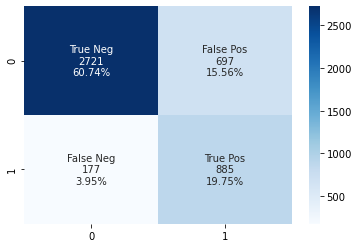

In [92]:
log_model = LogisticRegression(max_iter=1000000)
run_model(log_model,sampled_X_train, X_test, sampled_y_train, y_test)

### K Nearest Neighbours

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.84      0.89     13671
           1       0.86      0.94      0.90     13671

    accuracy                           0.89     27342
   macro avg       0.90      0.89      0.89     27342
weighted avg       0.90      0.89      0.89     27342

[[11535  2136]
 [  803 12868]]
F1: 0.8922535962083811
ROC_AUC: 0.8925096920488625
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------------------------------------------

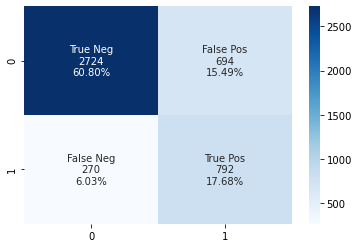

In [93]:
modelKNN = KNeighborsClassifier()
run_model(modelKNN,sampled_X_train, X_test, sampled_y_train, y_test)

### Naive Bayes

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.48      0.63     13671
           1       0.65      0.96      0.77     13671

    accuracy                           0.72     27342
   macro avg       0.78      0.72      0.70     27342
weighted avg       0.78      0.72      0.70     27342

[[ 6594  7077]
 [  588 13083]]
F1: 0.7029298197250398
ROC_AUC: 0.7196620583717358
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------------------------------------------

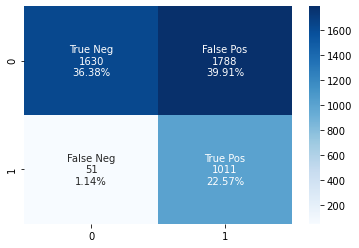

In [94]:
modelNAB = GaussianNB()
run_model(modelNAB,sampled_X_train, X_test, sampled_y_train, y_test)

### XGBoost

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     13671
           1       0.93      0.92      0.92     13671

    accuracy                           0.92     27342
   macro avg       0.92      0.92      0.92     27342
weighted avg       0.92      0.92      0.92     27342

[[12649  1022]
 [ 1031 12640]]
F1: 0.9249140435066823
ROC_AUC: 0.9249140516421623
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------------------------------------------

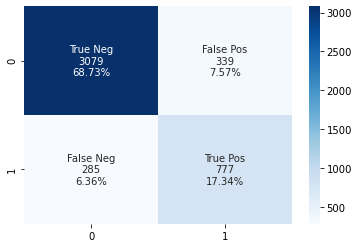

In [126]:
modelXGB = xgb.XGBClassifier()
run_model(modelXGB,sampled_X_train, X_test, sampled_y_train, y_test)

## Feature Selection
In this section, we will eliminate noise from the model.

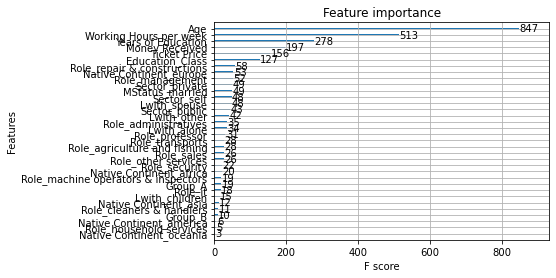

In [127]:
xgb.plot_importance(modelXGB)

In [128]:
# Fit model using each importance as a threshold
thresholds = np.sort(modelXGB.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(modelXGB, threshold=thresh, prefit=True)
    select_X_train = selection.transform(sampled_X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, sampled_y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    auc = roc_auc_score(y_test, y_pred)
    print("Thresh=%.9f, nFeatures=%d, auc: %.2f%%" % (thresh, select_X_train.shape[1], auc*100.0))

Thresh=0.000000000, nFeatures=38, auc: 81.62%
Thresh=0.000000000, nFeatures=38, auc: 81.62%
Thresh=0.000000000, nFeatures=38, auc: 81.62%
Thresh=0.000000000, nFeatures=38, auc: 81.62%
Thresh=0.003017367, nFeatures=34, auc: 81.62%
Thresh=0.003419919, nFeatures=33, auc: 81.60%
Thresh=0.004213297, nFeatures=32, auc: 81.46%
Thresh=0.004814375, nFeatures=31, auc: 81.85%
Thresh=0.004885243, nFeatures=30, auc: 82.06%
Thresh=0.005017536, nFeatures=29, auc: 81.61%
Thresh=0.005057052, nFeatures=28, auc: 81.89%
Thresh=0.005244754, nFeatures=27, auc: 81.57%
Thresh=0.005246541, nFeatures=26, auc: 81.54%
Thresh=0.005264810, nFeatures=25, auc: 81.46%
Thresh=0.006586012, nFeatures=24, auc: 81.62%
Thresh=0.006591879, nFeatures=23, auc: 81.74%
Thresh=0.006885780, nFeatures=22, auc: 81.91%
Thresh=0.007076622, nFeatures=21, auc: 81.33%
Thresh=0.007136249, nFeatures=20, auc: 81.15%
Thresh=0.007203378, nFeatures=19, auc: 81.80%
Thresh=0.007215912, nFeatures=18, auc: 81.64%
Thresh=0.008877571, nFeatures=17, 

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     13671
           1       0.92      0.92      0.92     13671

    accuracy                           0.92     27342
   macro avg       0.92      0.92      0.92     27342
weighted avg       0.92      0.92      0.92     27342

[[12568  1103]
 [ 1132 12539]]
F1: 0.9182575336742405
ROC_AUC: 0.9182576256308975
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------------------------------------------

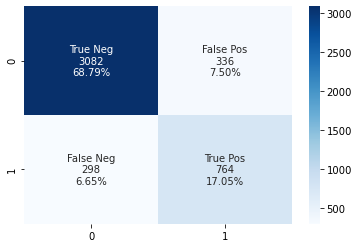

In [129]:
# I choose Threshold 0.013293631
VariableSelector = SelectFromModel(modelXGB, threshold=0.013293631, prefit=True)

cols = VariableSelector.get_support(indices=True)
selected_X_train = sampled_X_train.iloc[:,cols]
selected_X_test = X_test.iloc[:,cols]
modelXGB = xgb.XGBClassifier()
run_model(modelXGB,selected_X_train, selected_X_test, sampled_y_train, y_test)

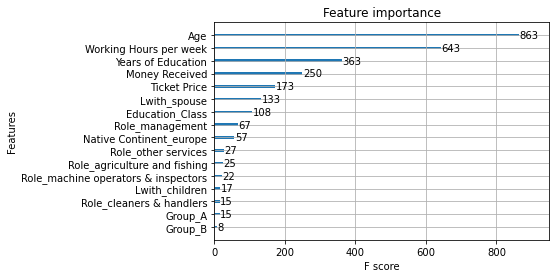

In [99]:
xgb.plot_importance(modelXGB)

### Hyperpatameterization of XGBoost

In [100]:
space = {'max_depth' : hp.choice('max_depth', range(2, 50, 1))
         , 'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01)
         , 'n_estimators' : hp.choice('n_estimators', range(10, 200, 5))
         , 'gamma' : hp.quniform('gamma', 0, 0.50, 0.01)
         , 'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1)
         , 'subsample' : hp.quniform('subsample', 0.1, 1, 0.01)
         , 'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01)}

In [131]:
optimizer_X_train = selected_X_train
optimizer_y_train = sampled_y_train

start_time = time.time()

best = fmin(fn=objective
          , space=space
          , algo=tpe.suggest
          , max_evals=25
          , trials=Trials()
          , verbose = True)
print("Best: ", best)
print("--- %s seconds ---" % (time.time() - start_time))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     13671
           1       0.92      0.82      0.86     13671

    accuracy                           0.87     27342
   macro avg       0.88      0.87      0.87     27342
weighted avg       0.88      0.87      0.87     27342

[[12657  1014]
 [ 2495 11176]]
F1: 0.8712850029248317
ROC_AUC: 0.8716626435520445
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------------------------------------------

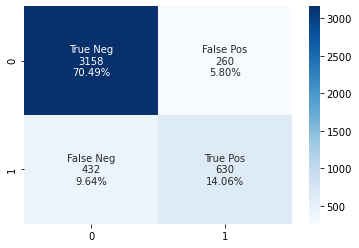

In [51]:
#######


modelXGB_HYPER = xgb.XGBClassifier(n_estimators = best['n_estimators']
                                 , max_depth = int(best['max_depth'])
                                 , learning_rate = best['learning_rate']
                                 , gamma = best['gamma']
                                 , min_child_weight = best['min_child_weight']
                                 , subsample = best['subsample']
                                 , colsample_bytree = best['colsample_bytree'])

run_model(modelXGB_HYPER,optimizer_X_train, selected_X_test, optimizer_y_train, y_test)

### H2O

In [52]:
import h2o
from h2o.automl import H2OAutoML

In [53]:
import os
MAXCORES = int(os.environ['NUMBER_OF_PROCESSORS']) - 2

In [54]:
h2o.init(nthreads=MAXCORES)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM AdoptOpenJDK (build 14+36, mixed mode, sharing)
  Starting server from C:\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\FABIOL~1\AppData\Local\Temp\tmpoc44yc8k
  JVM stdout: C:\Users\FABIOL~1\AppData\Local\Temp\tmpoc44yc8k\h2o_Fabio_Lopes_started_from_python.out
  JVM stderr: C:\Users\FABIOL~1\AppData\Local\Temp\tmpoc44yc8k\h2o_Fabio_Lopes_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Lisbon
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.1
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Fabio_Lopes_ly4j0r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.963 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


In [59]:
h2ofeed = optimizer_X_train.copy()
h2ofeed['Income'] = optimizer_y_train

In [60]:
train = h2o.H2OFrame(h2ofeed)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [61]:
# Identify predictors and response
x = train.columns
y = "Income"
x.remove(y)

In [62]:
train[y] = train[y].asfactor()

In [63]:
aml = H2OAutoML(max_runtime_secs=1800)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
22:19:15.132: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [64]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20201123_221915,0.970255,0.234972,0.973192,0.0979811,0.266014,0.0707634
GBM_grid__1_AutoML_20201123_221915_model_44,0.969351,0.224957,0.972425,0.0995172,0.264214,0.0698093
GBM_grid__1_AutoML_20201123_221915_model_58,0.969349,0.222839,0.972672,0.100505,0.263675,0.0695246
GBM_grid__1_AutoML_20201123_221915_model_57,0.969171,0.223995,0.972446,0.100797,0.264012,0.0697021
StackedEnsemble_BestOfFamily_AutoML_20201123_221915,0.969103,0.239147,0.971897,0.0992612,0.268142,0.0719002
GBM_grid__1_AutoML_20201123_221915_model_32,0.968689,0.228726,0.971488,0.100724,0.265505,0.0704929
GBM_grid__1_AutoML_20201123_221915_model_37,0.968363,0.228935,0.971466,0.100468,0.266629,0.0710912
GBM_grid__1_AutoML_20201123_221915_model_26,0.96793,0.230518,0.970711,0.101639,0.267135,0.0713614
GBM_grid__1_AutoML_20201123_221915_model_46,0.967873,0.23271,0.97099,0.102224,0.267921,0.0717817
GBM_3_AutoML_20201123_221915,0.967863,0.230517,0.970715,0.100212,0.267264,0.0714302


## Produce File for Submission

In [132]:
prepped_data_test = DataPreProcessing(data_test)
prepped_data_test = AlignDataframe(optimizer_X_train.columns,prepped_data_test)

In [133]:
predictions = modelXGB.predict(prepped_data_test)
prepped_data_test['Income'] = predictions
prepped_data_test[['Income']].to_csv('Submission_1.csv')

In [68]:
# Predict Using H2O
hf2 = h2o.H2OFrame(prepped_data_test)
preds = aml.predict(hf2)
predictions = preds.as_data_frame()
prepped_data_test['Income'] = predictions[['predict']]
final = prepped_data_test.copy()
final.reset_index(inplace=True)
final['Income'] = predictions[['predict']]
final.head()
final[['CITIZEN_ID','Income']].to_csv('Submission_2.csv', index=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
